In [1]:
import os
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt

# SAUCIE,MAGIC,deepImpute,scScope,scVI,knn_smoothing
methods = ["SAUCIE", "MAGIC", "deepImpute", "scScope", "scVI", "knn_smoothing"]
# Load imputed matrix
dataset_id = "63ff2c52-cb63-44f0-bac3-d0b33373e312"
disease = "Crohn disease"
tissue = "lamina propria of mucosa of colon"

adata = anndata.read_h5ad(f"./datasets/{dataset_id}.h5ad")

print(adata.obs.columns)
mask = (adata.obs["disease"] == disease) & (adata.obs["tissue"] == tissue)
adata = adata[mask]

Index(['biosample_id', 'n_genes', 'n_counts', 'Type', 'donor_id', 'Layer',
       'Celltype', 'organism_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'suspension_type', 'is_primary_data',
       'tissue_ontology_term_id', 'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'age group',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')


In [2]:
print(adata.obs)
print(adata.obs.organism.unique())
# total number of cells
print(adata.shape[0])


                           biosample_id  n_genes  n_counts  Type donor_id  \
cell_id                                                                     
N105446_L-ATTGTTCCAAACGTGG    N105446_L   2205.0   76317.0  NonI   105446   
N105446_L-TCGACGGGTGAGACCA    N105446_L   2088.0   67801.0  NonI   105446   
N105446_L-AGTAACCGTTAAGGGC    N105446_L   1862.0   58097.0  NonI   105446   
N105446_L-GCAGGCTTCGCTAAAC    N105446_L   5472.0   43418.0  NonI   105446   
N105446_L-ATCTTCATCTGAGAGG    N105446_L   5650.0   42871.0  NonI   105446   
...                                 ...      ...       ...   ...      ...   
N130084_L-GTGGTTACAGTTCCAA    N130084_L    305.0     488.0  NonI   130084   
N130084_L-TATCCTATCGTTCATT    N130084_L    294.0     490.0  NonI   130084   
N130084_L-TCATCCGGTATGATCC    N130084_L    268.0     453.0  NonI   130084   
N130084_L-GGTCACGGTTAGCGGA    N130084_L    289.0     442.0  NonI   130084   
N130084_L-TGGTGATAGTTGGAAT    N130084_L    224.0     344.0  NonI   130084   

In [3]:
import numpy as np
import json

# load marker genes
with open("./data/marker_genes.json", 'r') as f:
    marker_genes = json.load(f)

def expand_magic_matrix(original_matrix, imputed_matrix):
    """Expand MAGIC's imputed matrix to match original matrix dimensions."""
    expanded = np.zeros(original_matrix.shape)
    nonzero_counts = (original_matrix != 0).sum(axis=0)
    kept_genes = np.where(nonzero_counts >= 5)[0]
    for i, original_idx in enumerate(kept_genes):
        if i < imputed_matrix.shape[1]:
            expanded[:, original_idx] = imputed_matrix[:, i]
    return expanded

# Load imputed matrices for each method
imputed_matrices = []
valid_methods = []
for method in methods:
    # Try to load the imputed matrix
    try:
        # Construct the path (this would need to match your actual file structure)
        file_path = f"./output/{method}/{dataset_id}/{disease}/{tissue}.npy"
        imputed = np.load(file_path)
        if method == "MAGIC":
            # Expand MAGIC matrix to match original matrix dimensions
            imputed = expand_magic_matrix(adata.X, imputed)
        imputed_matrices.append(imputed)
        valid_methods.append(method)
        print(f"Loaded {method} matrix: {imputed.shape}")
    except:
        print(f"Failed to load {method}")

# Find the smallest number of genes across all matrices
min_genes = min([matrix.shape[1] for matrix in imputed_matrices])
print(f"Smallest number of genes across methods: {min_genes}")

# Filter all matrices to use only the first min_genes genes
filtered_matrices = []
for matrix in imputed_matrices:
    filtered_matrices.append(matrix[:, :min_genes])
    
# Also filter the original data
adata_filtered = adata[:, :min_genes].copy()

print(f"Filtered matrices to common dimensions: {adata_filtered.shape}")

# Define a function to calculate TH scores that handles sparse matrices properly
def calculate_th_scores(adata, imputed_matrices, methods):
    # Determine if sparse
    is_sparse = hasattr(adata.X, 'toarray')
    
    # Find zeros - for smaller matrices, we can just convert to dense
    if is_sparse:
        X_dense = adata.X.toarray()
        zero_mask = X_dense == 0
    else:
        zero_mask = adata.X == 0
        
    zero_indices = np.where(zero_mask)
    
    # Equal weights for all methods
    weights = {method: 1.0/len(methods) for method in methods}
    
    # Calculate scores
    n_zeros = len(zero_indices[0])
    scores = np.zeros(n_zeros)
    values = np.zeros(n_zeros)
    
    for i, method_name in enumerate(methods):
        imputed = imputed_matrices[i]
        weight = weights[method_name]
        
        # Extract values at zero positions
        imputed_values = np.zeros(n_zeros)
        for j, (r, c) in enumerate(zip(zero_indices[0], zero_indices[1])):
            imputed_values[j] = imputed[r, c]
        
        # Update scores (1 if imputed > 0, else 0)
        ZERO_TOLERANCE = 0
        scores += weight * (np.abs(imputed_values) >= ZERO_TOLERANCE).astype(float)
        
        # Update consensus values
        values += weight * imputed_values
    
    return {
        "zero_indices": zero_indices,
        "scores": scores,
        "values": values,
        "method_weights": weights,
        "valid_methods": methods,
    }

th_results = [calculate_th_scores(adata_filtered, filtered_matrices, valid_methods)]
print(f"Calculated TH scores for {len(th_results[0]['scores'])} zeros")


Loaded SAUCIE matrix: (8076, 27289)
Loaded MAGIC matrix: (8076, 27289)
Loaded deepImpute matrix: (8076, 27289)
Loaded scScope matrix: (8076, 27289)
Loaded scVI matrix: (8076, 27289)
Loaded knn_smoothing matrix: (8076, 27289)
Smallest number of genes across methods: 27289
Filtered matrices to common dimensions: (8076, 27289)
Calculated TH scores for 201453960 zeros


In [4]:
# Find the highest-scoring zero
scores = th_results[0]["scores"]
zero_indices = th_results[0]["zero_indices"]
values = th_results[0]["values"]
print("th_results:", th_results)

th_results: [{'zero_indices': (array([   0,    0,    0, ..., 8075, 8075, 8075]), array([    0,     1,     2, ..., 27286, 27287, 27288])), 'scores': array([1., 1., 1., ..., 1., 1., 1.]), 'values': array([ 1.72103537e-01,  8.57981108e-03,  4.63777256e-03, ...,
        1.11574477e-01, -3.70641259e-04,  1.24629445e+00]), 'method_weights': {'SAUCIE': 0.16666666666666666, 'MAGIC': 0.16666666666666666, 'deepImpute': 0.16666666666666666, 'scScope': 0.16666666666666666, 'scVI': 0.16666666666666666, 'knn_smoothing': 0.16666666666666666}, 'valid_methods': ['SAUCIE', 'MAGIC', 'deepImpute', 'scScope', 'scVI', 'knn_smoothing']}]


In [5]:
# measure the range of scores
def measure_score_range(th_results):
    score_ranges = {}
    for method in th_results[0]["valid_methods"]:
        scores = th_results[0]["scores"]
        values = th_results[0]["values"]
        
        # Get the indices of the zeros
        zero_indices = th_results[0]["zero_indices"]
        
        # Get the imputed values for the current method
        imputed_values = np.zeros(len(zero_indices[0]))
        for j, (r, c) in enumerate(zip(zero_indices[0], zero_indices[1])):
            imputed_values[j] = values[j]
        
        # Calculate the range of scores
        score_range = (np.min(scores), np.max(scores))
        score_ranges[method] = score_range
        
    return score_ranges
score_ranges = measure_score_range(th_results)

In [6]:
print(f"Score ranges for each method: {score_ranges}")

Score ranges for each method: {'SAUCIE': (0.9999999999999999, 0.9999999999999999), 'MAGIC': (0.9999999999999999, 0.9999999999999999), 'deepImpute': (0.9999999999999999, 0.9999999999999999), 'scScope': (0.9999999999999999, 0.9999999999999999), 'scVI': (0.9999999999999999, 0.9999999999999999), 'knn_smoothing': (0.9999999999999999, 0.9999999999999999)}


In [7]:
# print rankings in descending order
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_values = values[sorted_indices]
sorted_zero_indices = (zero_indices[0][sorted_indices], zero_indices[1][sorted_indices])
print("Ranked Trustworthness scores:")
for idx in range(len(sorted_scores[:20])):
    row = sorted_zero_indices[0][idx]
    col = sorted_zero_indices[1][idx]
    score = sorted_scores[idx]
    value = sorted_values[idx]
    gene_name = adata.var_names[col]
    cell_barcode = adata.obs_names[row]
    cell_type = adata.obs["Celltype"][row]
    # we also need to know for each method, the indicator score
    print(f"Rank {idx+1}: Row {row}, Col {col} - Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
    print(f"TH-Score: {score:.4f}, Consensus Value: {value:.4f}")
    for method in valid_methods:
        method_idx = valid_methods.index(method)
        imputed_value = filtered_matrices[method_idx][row, col]
        print(f"  {method}: Imputed Value: {imputed_value:.4f}")
    print()

# TH scores (0 or 1)
top_idx = np.argmax(scores)
top_row = zero_indices[0][top_idx]
top_col = zero_indices[1][top_idx]
top_score = scores[top_idx]
top_value = values[top_idx]

# Get gene and cell information
gene_name = adata.var_names[top_col]
cell_barcode = adata.obs_names[top_row]
cell_type = adata.obs["Celltype"][top_row]

print(f"Highest-ranked zero: Row {top_row}, Col {top_col}")
print(f"Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
print(f"TH-Score: {top_score:.4f}, Consensus Value: {top_value:.4f}")


Ranked Trustworthness scores:
Rank 1: Row 0, Col 0 - Gene: ENSG00000228463, Cell: Paneth cells (N105446_L-ATTGTTCCAAACGTGG)
TH-Score: 1.0000, Consensus Value: 0.1721
  SAUCIE: Imputed Value: 0.0310
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 0.0000
  scScope: Imputed Value: 1.0016
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 0.0000

Rank 2: Row 8075, Col 27288 - Gene: ENSG00000223726, Cell: Enterocytes CA1 CA2 CA4- (N130084_L-TGGTGATAGTTGGAAT)
TH-Score: 1.0000, Consensus Value: 1.2463
  SAUCIE: Imputed Value: 0.0021
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 0.0000
  scScope: Imputed Value: 7.4757
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 0.0000

Rank 3: Row 8075, Col 27287 - Gene: ENSG00000268316, Cell: Enterocytes CA1 CA2 CA4- (N130084_L-TGGTGATAGTTGGAAT)
TH-Score: 1.0000, Consensus Value: -0.0004
  SAUCIE: Imputed Value: -0.0022
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 0.0000
  scScope: Imputed 

In [8]:
# For that first position, what values do the 6 methods propose?
all_scores = []
for i, method_name in enumerate(valid_methods):
    imputed = filtered_matrices[i]
    value = imputed[top_row, top_col]
    all_scores.append(value)
    print(f"{method_name}: {value:.4f}")
# What’s the spread (min/max/mean)?
all_scores = np.array(all_scores)
print(f"Min: {np.min(all_scores):.4f}, Max: {np.max(all_scores):.4f}, Mean: {np.mean(all_scores):.4f}")
    

SAUCIE: 0.0310
MAGIC: 0.0000
deepImpute: 0.0000
scScope: 1.0016
scVI: 0.0000
knn_smoothing: 0.0000
Min: 0.0000, Max: 1.0016, Mean: 0.1721


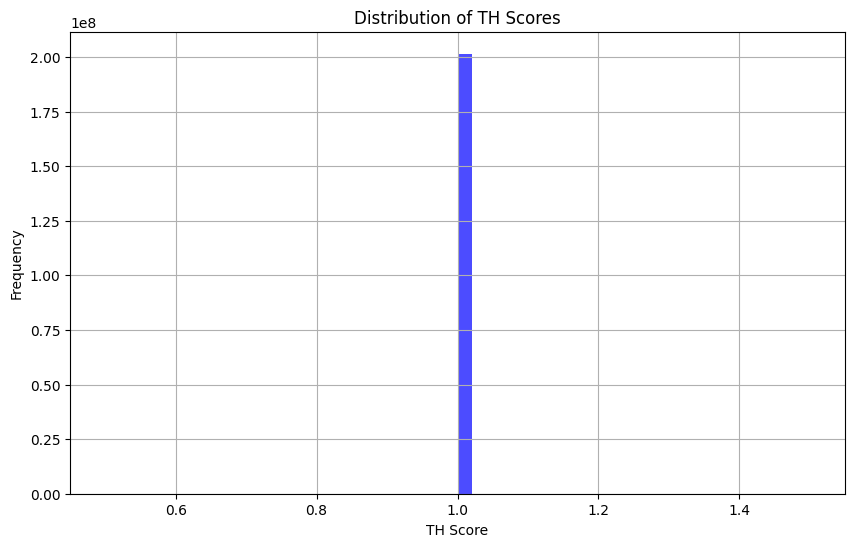

In [9]:
# Distribution graph of TH scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TH Scores')
plt.xlabel('TH Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [10]:
# print rankings in descending order
sorted_indices = np.argsort(values)[::-1]
sorted_scores = scores[sorted_indices]
sorted_values = values[sorted_indices]
sorted_zero_indices = (zero_indices[0][sorted_indices], zero_indices[1][sorted_indices])
print("Ranked Consensus values:")
for idx in range(len(sorted_values[:20])):
    row = sorted_zero_indices[0][idx]
    col = sorted_zero_indices[1][idx]
    score = sorted_scores[idx]
    value = sorted_values[idx]
    gene_name = adata.var_names[col]
    cell_barcode = adata.obs_names[row]
    cell_type = adata.obs["Celltype"][row]
    
    print(f"Rank {idx+1}: Row {row}, Col {col} - Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
    print(f"TH-Score: {score:.4f}, Consensus Value: {value:.4f}")
    for method in valid_methods:
        method_idx = valid_methods.index(method)
        imputed_value = filtered_matrices[method_idx][row, col]
        print(f"  {method}: Imputed Value: {imputed_value:.4f}")
    print()

# consensus value (weighted average of imputed values)
top_idx = np.argmax(values)
top_row = zero_indices[0][top_idx]
top_col = zero_indices[1][top_idx]

# Get gene and cell information
gene_name = adata.var_names[top_col]
cell_barcode = adata.obs_names[top_row]
cell_type = adata.obs["Celltype"][top_row]

print(f"Highest-ranked zero (with consensus values): Row {top_row}, Col {top_col}")
print(f"Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")

Ranked Consensus values:
Rank 1: Row 4256, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (I117351_L-GCACATACAAGCCATT)
TH-Score: 1.0000, Consensus Value: 6.2869
  SAUCIE: Imputed Value: 1.6164
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.4889
  scScope: Imputed Value: 21.8220
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 9.7940

Rank 2: Row 5250, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (N128400_L-GTTCCGTCATCCGATA)
TH-Score: 1.0000, Consensus Value: 5.5666
  SAUCIE: Imputed Value: 1.7874
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.7798
  scScope: Imputed Value: 17.0245
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 9.8080

Rank 3: Row 7169, Col 8602 - Gene: ENSG00000164816, Cell: Tuft cells (N178961_L-ATTCCCGAGCCATGCC)
TH-Score: 1.0000, Consensus Value: 5.5276
  SAUCIE: Imputed Value: 1.5079
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.0700
  scScope: Imputed Val

In [11]:
# For that first position, what values do the 6 methods propose?
all_values = []
for i, method_name in enumerate(valid_methods):
    imputed = filtered_matrices[i]
    value = imputed[top_row, top_col]
    all_values.append(value)
    print(f"{method_name}: {value:.4f}")
# What’s the spread (min/max/mean)?
all_values = np.array(all_values)
print(f"Min: {np.min(all_values):.4f}, Max: {np.max(all_values):.4f}, Mean: {np.mean(all_values):.4f}")
    

SAUCIE: 1.6164
MAGIC: 0.0000
deepImpute: 4.4889
scScope: 21.8220
scVI: 0.0000
knn_smoothing: 9.7940
Min: 0.0000, Max: 21.8220, Mean: 6.2869


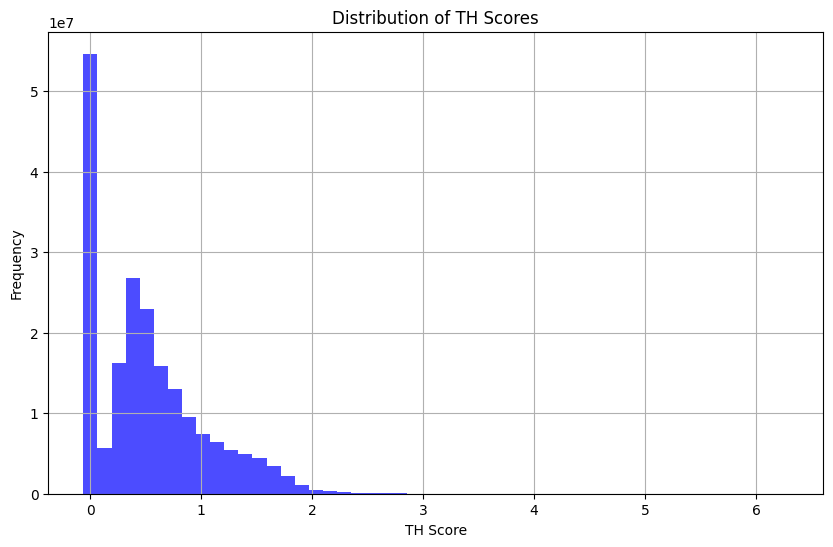

0.9999999999999999


In [12]:
# Distribution graph of TH scores
plt.figure(figsize=(10, 6))
plt.hist(values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TH Scores')
plt.xlabel('TH Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()
print(np.max(scores))


In [13]:
df = pd.DataFrame(scores)
stats = df.describe()
print(stats)

                 0
count  201453960.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0


In [14]:
df = pd.DataFrame(values)
stats = df.describe()
print(stats)

                  0
count  2.014540e+08
mean   5.250165e-01
std    4.922224e-01
min   -6.019307e-02
25%    1.690256e-02
50%    4.358563e-01
75%    7.846782e-01
max    6.286886e+00


In [15]:
# trustworthy score rank 1:
# so many 0.833s

# concensus value rank 1:
# Rank 1: Row 4256, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (I117351_L-GCACATACAAGCCATT) Consensus Value: 6.2947

In [16]:
import numpy as np
import json

def log_message(msg):
    print(msg)

def inspect_gene_names(adata):
    log_message(f"Gene name format example: first 5 genes - {', '.join(adata.var_names[:5])}")
    common_markers = ['MUC2', 'LGR5', 'OLFM4', 'LYZ', 'DEFA5']
    lowercase_var_names = [name.lower() for name in adata.var_names]
    for marker in common_markers:
        lower_marker = marker.lower()
        if lower_marker in lowercase_var_names:
            idx = lowercase_var_names.index(lower_marker)
            actual_name = adata.var_names[idx]
            log_message(f"Found marker {marker} as {actual_name}")
    if hasattr(adata.var, 'columns') and len(adata.var.columns) > 0:
        log_message(f"Additional gene metadata columns: {', '.join(adata.var.columns)}")
        symbol_cols = [col for col in adata.var.columns
                      if 'symbol' in col.lower() or 'name' in col.lower() or 'gene' in col.lower()]
        if symbol_cols:
            log_message(f"Potential gene symbol columns: {', '.join(symbol_cols)}")
            log_message(f"Sample from {symbol_cols[0]}: {adata.var[symbol_cols[0]].iloc[:5].tolist()}")
    return symbol_cols if 'symbol_cols' in locals() else []


def find_gene_mapping(adata, marker_genes):
    symbol_cols = inspect_gene_names(adata)
    gene_mapping = {}
    
    all_markers = set()
    for cell_type in marker_genes:
        all_markers.update(marker_genes[cell_type])
    
    for gene in all_markers:
        if gene in adata.var_names:
            gene_mapping[gene] = gene
            continue
            
        lowercase_var_names = [name.lower() for name in adata.var_names]
        if gene.lower() in lowercase_var_names:
            idx = lowercase_var_names.index(gene.lower())
            gene_mapping[gene] = adata.var_names[idx]
            continue
            
        for col in symbol_cols:
            if gene in adata.var[col].values:
                indices = adata.var.index[adata.var[col] == gene].tolist()
                if indices:
                    gene_mapping[gene] = indices[0]
                    break
    
    return gene_mapping

def compute_descending_ranks(vec):
    """Return 1-based ranks (largest=1) for a 1-D array in O(n log n)."""
    order = np.argsort(-vec)          # indices that would sort descending
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(vec)+1)
    return ranks

th_ranks       = compute_descending_ranks(scores)   # shape (n_cells,)
consensus_ranks = compute_descending_ranks(values)  # shape (n_cells,)
cell_index = {k: i for i, k in enumerate(adata.obs.index)}

with open("./data/marker_genes.json") as f:
    marker_genes = json.load(f)
gene_mapping = find_gene_mapping(adata, marker_genes)


for cell_type, markers in marker_genes.items():
    if 'Celltype' not in adata.obs.columns:
        print("Column 'Celltype' not found in adata.obs")
        break

    matching = adata.obs.index[adata.obs['Celltype'] == cell_type]
    if len(matching) == 0:
        continue

    sample_idx = cell_index[matching[0]]          # integer row index
    th_rank_sample       = th_ranks[sample_idx]   # one lookup
    consensus_rank_sample = consensus_ranks[sample_idx]

    for gene in markers:
        if gene not in gene_mapping:               # skip unmapped genes
            continue
        print(
            f"Cell Type: {cell_type:15} "
            f"Gene: {gene:7} "
            f"TH Rank: {th_rank_sample}/{len(scores)} {th_rank_sample/len(scores)*100:.2f}%, "
            f"Consensus Rank: {consensus_rank_sample}/{len(values)} {consensus_rank_sample/len(values)*100:.2f}%"
        )


Gene name format example: first 5 genes - ENSG00000228463, ENSG00000237094, ENSG00000228327, ENSG00000237491, ENSG00000177757
Additional gene metadata columns: feature_is_filtered, feature_name, feature_reference, feature_biotype, feature_length, feature_type
Potential gene symbol columns: feature_name
Sample from feature_name: ['ENSG00000228463.10', 'ENSG00000237094.13', 'ENSG00000228327.6', 'LINC01409', 'FAM87B']
Cell Type: Enterocytes BEST4 Gene: BEST4   TH Rank: 183/201453960 0.00%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: OTOP2   TH Rank: 183/201453960 0.00%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: CA7     TH Rank: 183/201453960 0.00%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: GUCA2A  TH Rank: 183/201453960 0.00%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: GUCA2B  TH Rank: 183/201453960 0.00%, Consensus Rank: 152958850/201453960 75.93%
C

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import ks_2samp, pearsonr, spearmanr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform


def calculate_complete_score(X_original, X_imputed, adata=None, marker_genes=None, clusters=None):
    """
    Calculate a comprehensive imputation quality score that addresses all suggested metrics.
    
    Parameters:
    -----------
    X_original : np.ndarray
        Original gene expression matrix
    X_imputed : np.ndarray
        Imputed gene expression matrix
    adata : AnnData, optional
        Original AnnData object for cell-type information
    marker_genes : dict, optional
        Dictionary of marker genes per cell type
    clusters : np.ndarray, optional
        Cell cluster assignments for within-cluster correlation
        
    Returns:
    --------
    dict
        Dictionary with all scores and the final composite score
    """
    # Initialize score components
    scores = {}
    
    # 1. Gene-gene correlation preservation
    # (a) Global correlation preservation
    gene_correlations = []
    n_genes_sample = min(1000, X_original.shape[1])
    gene_indices = np.random.choice(X_original.shape[1], n_genes_sample, replace=False)
    
    
    for i in range(min(100, len(gene_indices))):
        gene_idx = gene_indices[i]
        if (np.std(X_original[:, gene_idx].toarray().flatten() if hasattr(X_original, 'toarray') else X_original[:, gene_idx]) > 0 and 
            np.std(X_imputed[:, gene_idx].toarray().flatten() if hasattr(X_imputed, 'toarray') else X_imputed[:, gene_idx]) > 0):
            corr = np.corrcoef(X_original[:, gene_idx], X_imputed[:, gene_idx])[0, 1]
            if not np.isnan(corr):
                gene_correlations.append(corr)
    
    scores['gene_corr_global'] = np.mean(gene_correlations) if gene_correlations else 0
    
    # (b) Within-cluster correlation preservation (if clusters provided)
    if clusters is not None:
        within_cluster_correlations = []
        cluster_ids = np.unique(clusters)
        
        for cluster_id in cluster_ids:
            cluster_mask = clusters == cluster_id
            if np.sum(cluster_mask) < 5:  # Skip tiny clusters
                continue
                
            cluster_corrs = []
            for i in range(min(50, len(gene_indices))):
                gene_idx = gene_indices[i]
                orig_expr = X_original[cluster_mask, gene_idx]
                imp_expr = X_imputed[cluster_mask, gene_idx]
                
                if np.std(orig_expr) > 0 and np.std(imp_expr) > 0:
                    corr = np.corrcoef(orig_expr, imp_expr)[0, 1]
                    if not np.isnan(corr):
                        cluster_corrs.append(corr)
            
            if cluster_corrs:
                within_cluster_correlations.append(np.mean(cluster_corrs))
        
        scores['gene_corr_within_cluster'] = np.mean(within_cluster_correlations) if within_cluster_correlations else 0
    else:
        scores['gene_corr_within_cluster'] = scores['gene_corr_global']  # Fallback
    
    # 2. Preservation of zeros and non-zeros (FIXED: now with tolerance)
    ZERO_TOLERANCE = 1e-6  # Define a small epsilon for "zero" values
    
    zero_mask = X_original == 0
    zeros_preserved = np.mean(np.abs(X_imputed[zero_mask]) < ZERO_TOLERANCE) if np.sum(zero_mask) > 0 else 0
    
    nonzero_mask = X_original > 0
    nonzeros_preserved = np.mean(X_imputed[nonzero_mask] >= ZERO_TOLERANCE) if np.sum(nonzero_mask) > 0 else 0
    
    scores['preservation_zeros'] = zeros_preserved
    scores['preservation_nonzeros'] = nonzeros_preserved
    scores['preservation_overall'] = (zeros_preserved + nonzeros_preserved) / 2
    
    # 3. Distribution agreement
    imputed_zeros_mask = (X_original == 0) & (X_imputed >= ZERO_TOLERANCE)  # FIXED: use tolerance
    if np.sum(imputed_zeros_mask) > 0 and np.sum(nonzero_mask) > 0:
        # 3a. Calculate KS statistic between distributions
        orig_nonzeros = X_original[nonzero_mask].flatten()
        imputed_values = X_imputed[imputed_zeros_mask].flatten()
        
        # Sample for efficiency
        max_samples = 10000
        if len(orig_nonzeros) > max_samples:
            orig_nonzeros = np.random.choice(orig_nonzeros, max_samples, replace=False)
        if len(imputed_values) > max_samples:
            imputed_values = np.random.choice(imputed_values, max_samples, replace=False)
            
        ks_stat, _ = ks_2samp(orig_nonzeros, imputed_values)
        scores['distribution_ks'] = 1.0 - ks_stat  # Lower KS statistic is better, so 1-KS for higher=better
        
        # 3b. Mean-variance trend preservation
        orig_means = []
        orig_vars = []
        imp_means = []
        imp_vars = []
        
        for gene_idx in range(min(500, X_original.shape[1])):
            orig_gene = X_original[:, gene_idx]
            imp_gene = X_imputed[:, gene_idx]
            
            if np.sum(orig_gene > 0) > 0:
                orig_means.append(np.mean(orig_gene))
                orig_vars.append(np.var(orig_gene))
            
            if np.sum(imp_gene > 0) > 0:
                imp_means.append(np.mean(imp_gene))
                imp_vars.append(np.var(imp_gene))
        
        if orig_means and imp_means:
            orig_cv = np.sqrt(orig_vars) / (np.array(orig_means) + 1e-10)
            imp_cv = np.sqrt(imp_vars) / (np.array(imp_means) + 1e-10)
            
            try:
                cv_corr, _ = spearmanr(orig_cv, imp_cv)
                scores['mean_var_trend'] = max(0, cv_corr)  # Spearman correlation between CV values
            except:
                scores['mean_var_trend'] = 0
        else:
            scores['mean_var_trend'] = 0
            
        # Combine distribution metrics
        scores['distribution_score'] = 0.5 * scores['distribution_ks'] + 0.5 * scores['mean_var_trend']
    else:
        scores['distribution_ks'] = 1.0
        scores['mean_var_trend'] = 1.0
        scores['distribution_score'] = 1.0
    
    # 4. Cell-cell structure preservation
    # 4a. PCA correlation
    try:
        n_pcs = min(50, X_original.shape[0] - 1, X_original.shape[1] - 1)
        if n_pcs >= 2:
            # Only apply PCA on a subset of cells if dataset is large to save memory
            max_cells_for_pca = 5000
            if X_original.shape[0] > max_cells_for_pca:
                cell_indices = np.random.choice(X_original.shape[0], max_cells_for_pca, replace=False)
                pca_orig = PCA(n_components=n_pcs).fit_transform(X_original[cell_indices])
                pca_imp = PCA(n_components=n_pcs).fit_transform(X_imputed[cell_indices])
            else:
                pca_orig = PCA(n_components=n_pcs).fit_transform(X_original)
                pca_imp = PCA(n_components=n_pcs).fit_transform(X_imputed)
            
            # Calculate correlation between PC coordinates
            pc_corrs = []
            for i in range(n_pcs):
                corr, _ = pearsonr(pca_orig[:, i], pca_imp[:, i])
                if not np.isnan(corr):
                    pc_corrs.append(corr)
            
            scores['pc_correlation'] = np.mean(pc_corrs) if pc_corrs else 0
        else:
            scores['pc_correlation'] = 0
    except:
        scores['pc_correlation'] = 0
    
    # 4b. k-NN graph preservation - Using sampling for large datasets
    try:
        k = min(15, X_original.shape[0] - 1)
        if k >= 5:
            # Limit kNN analysis to a subset of cells if dataset is large
            max_cells_for_knn = 2000
            if X_original.shape[0] > max_cells_for_knn:
                cell_indices = np.random.choice(X_original.shape[0], max_cells_for_knn, replace=False)
                # Use PCA to reduce dimensions for kNN calculation
                n_dims = min(50, X_original.shape[1] - 1)
                if n_dims >= 2:
                    pca_orig = PCA(n_components=n_dims).fit_transform(X_original[cell_indices])
                    pca_imp = PCA(n_components=n_dims).fit_transform(X_imputed[cell_indices])
                else:
                    pca_orig = X_original[cell_indices]
                    pca_imp = X_imputed[cell_indices]
            else:
                # For smaller datasets, use more dimensions but still reduce with PCA
                n_dims = min(50, X_original.shape[1] - 1)
                if n_dims >= 2:
                    pca_orig = PCA(n_components=n_dims).fit_transform(X_original)
                    pca_imp = PCA(n_components=n_dims).fit_transform(X_imputed)
                else:
                    pca_orig = X_original
                    pca_imp = X_imputed
            
            # Create distance matrices
            dist_orig = squareform(pdist(pca_orig, 'euclidean'))
            dist_imp = squareform(pdist(pca_imp, 'euclidean'))
            
            # For each cell, get k nearest neighbors
            knn_overlap_sum = 0
            for i in range(len(dist_orig)):
                orig_nn = np.argsort(dist_orig[i])[1:k+1]  # Skip self
                imp_nn = np.argsort(dist_imp[i])[1:k+1]
                overlap = len(set(orig_nn) & set(imp_nn))
                knn_overlap_sum += overlap / k
            
            scores['knn_preservation'] = knn_overlap_sum / len(dist_orig)
        else:
            scores['knn_preservation'] = 0
    except Exception as e:
        log_message(f"Warning: kNN calculation failed: {str(e)}")
        scores['knn_preservation'] = 0
    
    # 4c. Clustering stability - Sample for large datasets
    try:
        if X_original.shape[0] >= 20:  # Need sufficient cells
            # Sample cells for clustering if dataset is large
            max_cells_for_cluster = 5000
            if X_original.shape[0] > max_cells_for_cluster:
                cell_indices = np.random.choice(X_original.shape[0], max_cells_for_cluster, replace=False)
                X_orig_sample = X_original[cell_indices]
                X_imp_sample = X_imputed[cell_indices]
            else:
                X_orig_sample = X_original
                X_imp_sample = X_imputed
            
            # Get number of clusters proportional to data size
            n_clusters = max(2, min(20, X_orig_sample.shape[0] // 50))
            
            # Cluster original and imputed data
            kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans_imp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            
            clusters_orig = kmeans_orig.fit_predict(X_orig_sample)
            clusters_imp = kmeans_imp.fit_predict(X_imp_sample)
            
            # Calculate ARI
            ari = adjusted_rand_score(clusters_orig, clusters_imp)
            scores['clustering_stability'] = max(0, ari)  # Ensure non-negative
            
            # Calculate silhouette improvement
            if X_orig_sample.shape[0] <= 2000:
                try:
                    sil_orig = silhouette_score(X_orig_sample, clusters_orig)
                    sil_imp = silhouette_score(X_imp_sample, clusters_imp)
                    scores['silhouette_improvement'] = max(0, (sil_imp - sil_orig + 1) / 2)  # Scale to [0,1]
                except:
                    scores['silhouette_improvement'] = 0.5  # Neutral if can't compute
            else:
                scores['silhouette_improvement'] = 0.5  # Skip for very large datasets
        else:
            scores['clustering_stability'] = 0
            scores['silhouette_improvement'] = 0.5
    except Exception as e:
        log_message(f"Warning: Clustering calculation failed: {str(e)}")
        scores['clustering_stability'] = 0
        scores['silhouette_improvement'] = 0.5
    
    # 5. Marker gene enrichment (biological score)
    if marker_genes and adata is not None:
        marker_score = calculate_marker_agreement(X_imputed, marker_genes, adata)
        scores['marker_agreement'] = marker_score
    else:
        scores['marker_agreement'] = 0.5  # Neutral if markers not available
    
    # Calculate composite score - weighted geometric mean for balanced influence
    # Define the weights explicitly for transparency
    weights = {
        'gene_correlation': 0.25,
        'preservation': 0.20,
        'distribution': 0.15,
        'cell_structure': 0.20,
        'biological_signal': 0.20
    }
    
    # First, ensure all scores are in [0,1] range and compile them into main categories
    main_scores = {
        'gene_correlation': 0.6 * scores['gene_corr_global'] + 0.4 * scores['gene_corr_within_cluster'],
        'preservation': scores['preservation_overall'],
        'distribution': scores['distribution_score'],
        'cell_structure': (0.3 * scores['pc_correlation'] + 
                          0.3 * scores['knn_preservation'] + 
                          0.2 * scores['clustering_stability'] + 
                          0.2 * scores['silhouette_improvement']),
        'biological_signal': scores['marker_agreement']
    }
    
    # Calculate Z-scores to standardize
    z_scores = {}
    for key, value in main_scores.items():
        z_scores[key] = max(0.01, value)  # Ensure positive for geometric mean
    
    # Weighted geometric mean
    log_scores = np.array([weights[k] * np.log(z_scores[k]) for k in weights.keys()])
    composite_score = np.exp(np.sum(log_scores) / np.sum(list(weights.values())))
    
    # Add composite score
    scores['composite_score'] = composite_score
    
    # Add main category scores
    for key, value in main_scores.items():
        scores[key] = value
    
    # Log all scores
    log_message(f"  Gene correlation score: {main_scores['gene_correlation']:.4f}")
    log_message(f"  Preservation score: {main_scores['preservation']:.4f}")
    log_message(f"  Distribution score: {main_scores['distribution']:.4f}")
    log_message(f"  Cell structure score: {main_scores['cell_structure']:.4f}")
    log_message(f"  Biological signal score: {main_scores['biological_signal']:.4f}")
    log_message(f"  Final composite score: {composite_score:.4f}")
    log_message(f"  Metric weights: {weights}")
    
    return scores

def calculate_marker_agreement(X, marker_genes, adata):
    """
    Calculate the marker gene agreement score across all cells.
    Updated to use zero tolerance and be more memory-efficient.
    """
    # Set zero tolerance for numeric stability
    ZERO_TOLERANCE = 1e-6
    
    # Create gene index lookup
    gene2idx = {}
    if 'feature_name' in adata.var.columns:
        for i, (ensembl_id, feature_name) in enumerate(zip(adata.var_names, adata.var['feature_name'])):
            if isinstance(feature_name, str):
                # Store gene symbol -> index mapping
                gene2idx[feature_name] = i
                
                # Also try without version number if present
                if '.' in feature_name:
                    base_name = feature_name.split('.')[0]
                    gene2idx[base_name] = i

    # Print some debug info
    print(f"Loaded {len(gene2idx)} unique gene names from feature_name column")
    if len(gene2idx) > 0:
        print(f"Sample gene names: {list(gene2idx.keys())[:5]}")
        
        # Check if any marker genes match
        for cell_type, markers in marker_genes.items():
            found_markers = [m for m in markers if m in gene2idx]
            if found_markers:
                print(f"Found {len(found_markers)} markers for {cell_type}: {', '.join(found_markers)}")

    # Check if marker genes exist in the dataset
    missing_markers = []
    for cell_type, markers in marker_genes.items():
        for marker in markers:
            if marker not in gene2idx:
                missing_markers.append((cell_type, marker))
    
    if missing_markers:
        log_message(f"Warning: {len(missing_markers)} marker genes not found in dataset:")
        for cell_type, marker in missing_markers[:10]:  # Show first 10
            log_message(f"  {cell_type}: {marker}")
        if len(missing_markers) > 10:
            log_message(f"  ... and {len(missing_markers) - 10} more")
    
    # Cell type to index
    if "Celltype" in adata.obs.columns:
        cell_types = adata.obs["Celltype"].values
        unique_cell_types = np.unique(cell_types)
        log_message(f"Found {len(unique_cell_types)} cell types in data")
        
        # Create a mapping from marker gene cell types to annotation cell types
        cell_type_mapping = {}
        for marker_type in marker_genes.keys():
            # Find matching cell types by prefix (ignoring the suffix in parentheses)
            matches = [ct for ct in unique_cell_types if ct == marker_type]
            if matches:
                cell_type_mapping[marker_type] = matches
                log_message(f"Mapped '{marker_type}' to {len(matches)} cell types: {', '.join(matches)}")
        
        if not cell_type_mapping:
            log_message("Could not map any marker gene cell types to annotation cell types")
            return 0.0
        
        # Initialize score components
        specificity_score = 0.0
        expression_score = 0.0
        valid_pairs = 0
        
        # Check if X is sparse
        is_sparse = hasattr(X, 'toarray')
        
        # For each cell type with markers
        for marker_type, markers in marker_genes.items():
            if marker_type not in cell_type_mapping:
                continue
                
            # Get all matching cell types
            matching_types = cell_type_mapping[marker_type]
            
            # Create a mask for all cells of these types
            type_mask = np.zeros(X.shape[0], dtype=bool)
            for ct in matching_types:
                type_mask = type_mask | (cell_types == ct)
            
            if sum(type_mask) == 0:
                continue
            
            # Get indices of the marker genes present in our dataset
            marker_indices = [gene2idx[g] for g in markers if g in gene2idx]
            if len(marker_indices) == 0:
                continue
            
            # Process each marker gene - memory efficient approach
            for marker_idx in marker_indices:
                # Calculate in batches if dataset is large
                if X.shape[0] > 10000:
                    # Use batched processing for large datasets
                    batch_size = 5000
                    n_batches = (X.shape[0] + batch_size - 1) // batch_size
                    
                    # Initialize accumulators
                    sum_in_type = 0
                    count_in_type = 0
                    sum_in_others = 0
                    count_in_others = 0
                    sum_expr_in_type = 0
                    
                    for b in range(n_batches):
                        start_idx = b * batch_size
                        end_idx = min((b + 1) * batch_size, X.shape[0])
                        batch_mask = type_mask[start_idx:end_idx]
                        
                        # Get expression values for this batch
                        if is_sparse:
                            # Extract values for this batch and marker
                            batch_expr = X[start_idx:end_idx, marker_idx].toarray().flatten()
                        else:
                            batch_expr = X[start_idx:end_idx, marker_idx]
                        
                        # Sum expression in correct type
                        batch_in_type = batch_expr[batch_mask]
                        sum_in_type += np.sum(batch_in_type)
                        count_in_type += len(batch_in_type)
                        
                        # Sum expression in other types
                        batch_in_others = batch_expr[~batch_mask]
                        sum_in_others += np.sum(batch_in_others)
                        count_in_others += len(batch_in_others)
                        
                        # Calculate expression fraction (% of cells expressing)
                        # FIXED: Use zero tolerance for expression check
                        sum_expr_in_type += np.sum(batch_in_type >= ZERO_TOLERANCE)
                    
                    # Calculate means
                    expr_in_type = sum_in_type / max(1, count_in_type)
                    expr_in_others = sum_in_others / max(1, count_in_others)
                    expression = sum_expr_in_type / max(1, count_in_type)
                    
                else:
                    # For smaller datasets, calculate directly
                    if is_sparse:
                        marker_values = X[:, marker_idx].toarray().flatten()
                    else:
                        marker_values = X[:, marker_idx]
                        
                    # Expression in correct cell type
                    expr_in_type = np.mean(marker_values[type_mask])
                    
                    # Expression in other cell types
                    expr_in_others = np.mean(marker_values[~type_mask]) if sum(~type_mask) > 0 else 0
                    
                    # Expression level: What fraction of cells of this type express the marker
                    # FIXED: Use zero tolerance for expression check
                    expression = np.mean(marker_values[type_mask] >= ZERO_TOLERANCE)
                
                # 1. Specificity: How much more expressed in correct type
                if expr_in_others > ZERO_TOLERANCE:  # FIXED: Use zero tolerance
                    ratio = expr_in_type / expr_in_others
                    specificity = np.tanh(ratio - 1)  # Bounded growth function
                else:
                    specificity = 1.0 if expr_in_type > ZERO_TOLERANCE else 0.0  # FIXED: Use zero tolerance
                
                # Combine scores
                specificity_score += specificity
                expression_score += expression
                valid_pairs += 1
        
        # Return combined score, normalized by number of marker-celltype pairs
        if valid_pairs > 0:
            final_score = (0.7 * specificity_score + 0.3 * expression_score) / valid_pairs
            log_message(f"Calculated marker agreement score with {valid_pairs} valid cell type/marker pairs: {final_score:.4f}")
            return final_score
        else:
            log_message("No valid cell type/marker gene pairs found")
            return 0.0
    else:
        # If no cell type annotation available, use a simpler approach
        log_message("No cell type annotations found - using general marker expression score")
        
        # Initialize score
        expression_score = 0.0
        valid_pairs = 0
        
        # For all marker genes (regardless of cell type)
        for cell_type, markers in marker_genes.items():
            # Get indices of marker genes
            marker_indices = [gene2idx[g] for g in markers if g in gene2idx]
            
            # Check if X is sparse
            is_sparse = hasattr(X, 'toarray')
            
            for marker_idx in marker_indices:
                # Get gene expression
                if is_sparse:
                    marker_values = X[:, marker_idx].toarray().flatten()
                else:
                    marker_values = X[:, marker_idx]
                
                # Calculate expression across all cells (% of cells with non-zero expression)
                # FIXED: Use zero tolerance for expression check
                expr = np.mean(marker_values >= ZERO_TOLERANCE)
                expression_score += expr
                valid_pairs += 1
        
        # Return overall score
        if valid_pairs > 0:
            score = expression_score / valid_pairs
            log_message(f"Calculated general marker expression score: {score:.4f}")
            return score
        else:
            log_message("No valid marker genes found")
            return 0.0

def calculate_marker_based_weights(original_matrix, imputed_matrices, marker_genes, adata):
    """
    Calculate weights for each imputation method based on marker gene agreement improvement.
    Now with proper normalization and sparse matrix handling.
    """
    weights = []
    
    # Normalize original matrix to ensure consistent scale
    original_norm = log1p_cpm(original_matrix)
    
    # Get cell type annotations
    if "Celltype" in adata.obs.columns:
        cell_types = adata.obs["Celltype"].values
    else:
        # If no cell type annotation, create a dummy one
        is_large_matrix = original_matrix.shape[0] > 10000
        
        if is_large_matrix:
            # For large matrices, use simple clusters to avoid memory issues
            n_clusters = min(10, original_matrix.shape[0] // 50)
            # Sample a subset for clustering
            sample_size = min(5000, original_matrix.shape[0])
            sample_indices = np.random.choice(original_matrix.shape[0], sample_size, replace=False)
            
            # Get matrix subset for clustering
            if hasattr(original_matrix, 'toarray'):
                X_sample = original_norm[sample_indices].toarray()
            else:
                X_sample = original_norm[sample_indices]
                
            # Cluster the subset
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_ids_sample = kmeans.fit_predict(X_sample)
            
            # Assign all cells to a cluster (use 0 for non-sampled)
            cell_types = np.zeros(original_matrix.shape[0], dtype=int)
            cell_types[sample_indices] = cluster_ids_sample
        else:
            # For smaller matrices, cluster all cells
            n_clusters = min(10, original_matrix.shape[0] // 10)
            
            # Convert to dense if needed
            if hasattr(original_matrix, 'toarray'):
                X_for_clustering = original_norm.toarray()
            else:
                X_for_clustering = original_norm
                
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cell_types = kmeans.fit_predict(X_for_clustering)
        
        cell_types = np.array([f"Cluster_{i}" for i in cell_types])
    
    # Calculate baseline marker agreement score
    baseline_score = calculate_marker_agreement(original_norm, marker_genes, adata)
    
    # Calculate improvement for each method
    for i, imputed in enumerate(imputed_matrices):
        # Normalize imputed matrix to ensure same scale
        imputed_norm = log1p_cpm(imputed)
        
        # Calculate marker agreement
        score = calculate_marker_agreement(imputed_norm, marker_genes, adata)
        improvement = max(0, score - baseline_score)  # Only consider positive improvements
        weights.append(improvement + 0.01)  # Add small constant to avoid zero weights
    
    # Normalize weights
    weights = np.array(weights)
    return weights / np.sum(weights)


In [18]:
def find_improved_marker_gene_cutoffs(adata, scores, values, zero_indices, marker_genes):
    """
    Enhanced version of the marker gene cutoff finder with better debugging and flexibility.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with cell annotations
    scores : np.ndarray
        TH-scores for zero values in the matrix
    values : np.ndarray
        Consensus values for zero values in the matrix
    zero_indices : tuple
        Tuple of arrays with row and column indices of zeros
    marker_genes : dict
        Dictionary mapping cell types to marker genes
    
    Returns:
    --------
    dict
        Dictionary with cutoffs for each cell type and gene
    """
    import numpy as np
    from sklearn.metrics import precision_recall_curve, f1_score
    
    # Check if cell type annotation is available
    if 'Celltype' not in adata.obs.columns:
        print("Column 'Celltype' not found in adata.obs")
        return {}, {}
    
    # Print out some debugging information
    print(f"Data dimensions: {adata.shape}")
    print(f"Number of zero entries: {len(zero_indices[0])}")
    print(f"Number of cell types: {adata.obs['Celltype'].nunique()}")
    print(f"Cell types: {', '.join(adata.obs['Celltype'].unique())}")
    
    # Create gene name mapping - handle different name formats
    gene_name_to_idx = {}
    
    # First try exact matches
    for i, name in enumerate(adata.var_names):
        gene_name_to_idx[name] = i
    
    # Then try looking for symbol column if available
    if 'feature_name' in adata.var.columns:
        print("Using 'feature_name' column for gene mapping")
        for i, (idx, symbol) in enumerate(zip(adata.var_names, adata.var['feature_name'])):
            if isinstance(symbol, str):
                gene_name_to_idx[symbol] = i
    
    # Try ENSG to gene symbol mapping if needed
    marker_gene_matches = {}
    for cell_type, genes in marker_genes.items():
        marker_gene_matches[cell_type] = []
        for gene in genes:
            found = False
            
            # Try direct match
            if gene in gene_name_to_idx:
                marker_gene_matches[cell_type].append((gene, gene_name_to_idx[gene]))
                found = True
                continue
                
            # Try case-insensitive match
            gene_lower = gene.lower()
            for name in gene_name_to_idx:
                if name.lower() == gene_lower:
                    marker_gene_matches[cell_type].append((gene, gene_name_to_idx[name]))
                    found = True
                    break
            
            if not found:
                print(f"Could not find gene '{gene}' in dataset")
    
    # Print marker gene matches
    for cell_type, matches in marker_gene_matches.items():
        if matches:
            print(f"Found {len(matches)}/{len(marker_genes[cell_type])} marker genes for {cell_type}")
        else:
            print(f"WARNING: Found 0 marker genes for {cell_type}")
    
    # Dictionary to store results: {cell_type: {gene: {'th_cutoff': value, 'consensus_cutoff': value}}}
    optimal_cutoffs = {}
    
    # Process each cell type
    for cell_type, marker_matches in marker_gene_matches.items():
        # Skip if no marker genes matched
        if not marker_matches:
            continue
            
        # Get indices of cells with this cell type
        target_cell_mask = adata.obs['Celltype'] == cell_type
        if np.sum(target_cell_mask) == 0:
            print(f"No cells found with type '{cell_type}'")
            continue
            
        target_cell_indices = np.where(target_cell_mask)[0]
        optimal_cutoffs[cell_type] = {}
        
        # For each marker gene
        for gene_name, gene_idx in marker_matches:
            # Find all zero entries for this gene
            col_mask = zero_indices[1] == gene_idx
            if np.sum(col_mask) == 0:
                print(f"No zero entries found for gene '{gene_name}' (idx {gene_idx})")
                continue
                
            # Get positions in the scores and values arrays
            gene_positions = np.where(col_mask)[0]
            
            # Get corresponding row indices (cells)
            cell_indices = zero_indices[0][gene_positions]
            
            # Get scores and values for these positions
            gene_scores = scores[gene_positions]
            gene_values = values[gene_positions]
            
            # Create binary labels for these cells (1 for target cell type, 0 for others)
            cell_labels = np.isin(cell_indices, target_cell_indices).astype(int)
            
            # Count positive examples
            positive_count = np.sum(cell_labels)
            if positive_count == 0:
                print(f"No cells of type '{cell_type}' have zero values for gene '{gene_name}'")
                continue
                
            print(f"Processing {cell_type} / {gene_name}: Found {positive_count} positive cells out of {len(cell_labels)} cells with zeros")
            
            # Try finding TH-score cutoff
            # Instead of using precision-recall curve which might be too strict,
            # let's try a simple approach: test different percentiles
            
            # For TH-scores
            th_cutoffs = []
            for percentile in [50, 60, 70, 80, 90, 95, 99]:
                cutoff = np.percentile(gene_scores, percentile)
                predictions = (gene_scores >= cutoff).astype(int)
                if np.sum(predictions) > 0:  # Avoid div by zero
                    precision = np.sum(predictions & cell_labels) / np.sum(predictions)
                    recall = np.sum(predictions & cell_labels) / np.sum(cell_labels)
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    th_cutoffs.append((cutoff, f1, precision, recall))
            
            # Get best cutoff by F1 score
            if th_cutoffs:
                th_cutoff, th_f1, th_precision, th_recall = max(th_cutoffs, key=lambda x: x[1])
                print(f"  TH-score cutoff: {th_cutoff:.4f}, F1: {th_f1:.4f}, Precision: {th_precision:.4f}, Recall: {th_recall:.4f}")
            else:
                th_cutoff, th_f1, th_precision, th_recall = None, 0, 0, 0
                print(f"  No valid TH-score cutoff found")
            
            # For consensus values
            val_cutoffs = []
            for percentile in [50, 60, 70, 80, 90, 95, 99]:
                cutoff = np.percentile(gene_values, percentile)
                predictions = (gene_values >= cutoff).astype(int)
                if np.sum(predictions) > 0:  # Avoid div by zero
                    precision = np.sum(predictions & cell_labels) / np.sum(predictions)
                    recall = np.sum(predictions & cell_labels) / np.sum(cell_labels)
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    val_cutoffs.append((cutoff, f1, precision, recall))
            
            # Get best cutoff by F1 score
            if val_cutoffs:
                val_cutoff, val_f1, val_precision, val_recall = max(val_cutoffs, key=lambda x: x[1])
                print(f"  Consensus value cutoff: {val_cutoff:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
            else:
                val_cutoff, val_f1, val_precision, val_recall = None, 0, 0, 0
                print(f"  No valid consensus value cutoff found")
            
            # Store results
            optimal_cutoffs[cell_type][gene_name] = {
                'th_cutoff': th_cutoff,
                'th_f1': th_f1,
                'th_precision': th_precision,
                'th_recall': th_recall,
                'consensus_cutoff': val_cutoff,
                'consensus_f1': val_f1,
                'consensus_precision': val_precision,
                'consensus_recall': val_recall
            }
    
    # Create summary metrics
    cell_type_metrics = {}
    for cell_type in optimal_cutoffs:
        if not optimal_cutoffs[cell_type]:
            continue
            
        th_metrics = [(gene, info['th_f1'], info['th_cutoff']) 
                    for gene, info in optimal_cutoffs[cell_type].items() 
                    if info['th_cutoff'] is not None]
        
        val_metrics = [(gene, info['consensus_f1'], info['consensus_cutoff']) 
                     for gene, info in optimal_cutoffs[cell_type].items() 
                     if info['consensus_cutoff'] is not None]
        
        best_th = max(th_metrics, key=lambda x: x[1]) if th_metrics else (None, 0, None)
        best_val = max(val_metrics, key=lambda x: x[1]) if val_metrics else (None, 0, None)
        
        cell_type_metrics[cell_type] = {
            'avg_th_f1': np.mean([m[1] for m in th_metrics]) if th_metrics else 0,
            'best_th_gene': best_th[0],
            'best_th_f1': best_th[1],
            'best_th_cutoff': best_th[2],
            'avg_consensus_f1': np.mean([m[1] for m in val_metrics]) if val_metrics else 0,
            'best_consensus_gene': best_val[0],
            'best_consensus_f1': best_val[1],
            'best_consensus_cutoff': best_val[2]
        }
    
    # Print summary of results
    print("\nSummary of optimal cutoffs:")
    for cell_type, metrics in cell_type_metrics.items():
        print(f"\nCell Type: {cell_type}")
        print(f"  Best TH-Score marker: {metrics['best_th_gene']} (F1: {metrics['best_th_f1']:.4f})")
        if metrics['best_th_gene']:
            print(f"  - Cutoff: {metrics['best_th_cutoff']:.4f}")
            
        print(f"  Best Consensus Value marker: {metrics['best_consensus_gene']} (F1: {metrics['best_consensus_f1']:.4f})")
        if metrics['best_consensus_gene']:
            print(f"  - Cutoff: {metrics['best_consensus_cutoff']:.4f}")
    
    return optimal_cutoffs, cell_type_metrics

cutoffs, metrics = find_improved_marker_gene_cutoffs(adata, scores, values, zero_indices, marker_genes)

Data dimensions: (8076, 27289)
Number of zero entries: 201453960
Number of cell types: 13
Cell types: Paneth cells, Goblet cells MUC2 TFF1, Goblet cells MUC2 TFF1-, Enterocytes CA1 CA2 CA4-, Epithelial Cycling cells, Stem cells OLFM4 LGR5, Enteroendocrine cells, Enterocytes TMIGD1 MEP1A, Stem cells OLFM4 PCNA, Stem cells OLFM4, Enterocytes BEST4, Tuft cells, Goblet cells SPINK4
Using 'feature_name' column for gene mapping
Could not find gene 'FCGBP' in dataset
Found 7/7 marker genes for Enterocytes BEST4
Found 5/6 marker genes for Goblet cells MUC2 TFF1
Found 2/2 marker genes for Tuft cells
Found 2/2 marker genes for Goblet cells SPINK4
Found 4/4 marker genes for Enterocytes TMIGD1 MEP1A
Found 2/2 marker genes for Enterocytes CA1 CA2 CA4-
Found 1/1 marker genes for Goblet cells MUC2 TFF1-
Found 3/3 marker genes for Epithelial Cycling cells
Found 4/4 marker genes for Enteroendocrine cells
Found 2/2 marker genes for Stem cells OLFM4
Found 3/3 marker genes for Stem cells OLFM4 LGR5
Found 

In [29]:
def find_best_marker_gene_cutoffs(adata, scores, values, zero_indices, marker_genes):
    """
    Find the best cutoffs for marker genes that can identify cell types without conflicts.
    Focus on consensus values which show better discrimination.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with cell annotations
    scores : np.ndarray
        TH-scores for zero values in the matrix
    values : np.ndarray
        Consensus values for zero values in the matrix
    zero_indices : tuple
        Tuple of arrays with row and column indices of zeros
    marker_genes : dict
        Dictionary mapping cell types to marker genes
    
    Returns:
    --------
    dict
        Dictionary with best cutoffs and stats for each cell type
    """
    import numpy as np
    from sklearn.metrics import precision_recall_curve, f1_score
    
    # Check if cell type annotation is available
    if 'Celltype' not in adata.obs.columns:
        print("Column 'Celltype' not found in adata.obs")
        return {}
    
    # Create gene name mapping
    gene_name_to_idx = {}
    
    # First try exact matches
    for i, name in enumerate(adata.var_names):
        gene_name_to_idx[name] = i
    
    # Then try looking for symbol column if available
    if 'feature_name' in adata.var.columns:
        for i, (idx, symbol) in enumerate(zip(adata.var_names, adata.var['feature_name'])):
            if isinstance(symbol, str):
                gene_name_to_idx[symbol] = i
    
    # Match marker genes to dataset
    marker_gene_matches = {}
    for cell_type, genes in marker_genes.items():
        marker_gene_matches[cell_type] = []
        for gene in genes:
            if gene in gene_name_to_idx:
                marker_gene_matches[cell_type].append((gene, gene_name_to_idx[gene]))
                continue
                
            # Try case-insensitive match
            gene_lower = gene.lower()
            for name in gene_name_to_idx:
                if name.lower() == gene_lower:
                    marker_gene_matches[cell_type].append((gene, gene_name_to_idx[name]))
                    break
    
    # Find best markers and cutoffs for each cell type
    cell_type_results = {}
    
    # First pass: find all potential marker gene cutoffs
    all_markers_info = {}
    
    for cell_type, marker_matches in marker_gene_matches.items():
        # Skip if no marker genes matched
        if not marker_matches:
            continue
            
        # Get indices of cells with this cell type
        target_cell_mask = adata.obs['Celltype'] == cell_type
        if np.sum(target_cell_mask) == 0:
            continue
            
        target_cell_indices = np.where(target_cell_mask)[0]
        all_markers_info[cell_type] = []
        
        # For each marker gene
        for gene_name, gene_idx in marker_matches:
            # Find all zero entries for this gene
            col_mask = zero_indices[1] == gene_idx
            if np.sum(col_mask) == 0:
                continue
                
            # Get positions in the scores and values arrays
            gene_positions = np.where(col_mask)[0]
            
            # Get corresponding row indices (cells)
            cell_indices = zero_indices[0][gene_positions]
            
            # Get scores and values for these positions
            gene_scores = scores[gene_positions]
            gene_values = values[gene_positions]
            
            # Create binary labels for these cells (1 for target cell type, 0 for others)
            cell_labels = np.isin(cell_indices, target_cell_indices).astype(int)
            
            # Skip if no positive examples
            positive_count = np.sum(cell_labels)
            if positive_count == 0:
                continue
                
            # Try finding cutoffs
            th_cutoff_info = find_best_cutoff(gene_scores, cell_labels)
            val_cutoff_info = find_best_cutoff(gene_values, cell_labels)
            
            # Store marker information
            marker_info = {
                'gene': gene_name,
                'gene_idx': gene_idx,
                'cell_type': cell_type,
                'th_cutoff': th_cutoff_info['cutoff'],
                'th_f1': th_cutoff_info['f1'],
                'th_precision': th_cutoff_info['precision'],
                'th_recall': th_cutoff_info['recall'],
                'val_cutoff': val_cutoff_info['cutoff'],
                'val_f1': val_cutoff_info['f1'],
                'val_precision': val_cutoff_info['precision'],
                'val_recall': val_cutoff_info['recall'],
                'positions': gene_positions,
                'cell_indices': cell_indices
            }
            
            all_markers_info[cell_type].append(marker_info)
    
    # Second pass: resolve conflicts and find best markers
    # Sort all markers by F1 score (consensus values) for prioritization
    all_markers_flat = []
    for cell_type, markers in all_markers_info.items():
        for marker in markers:
            all_markers_flat.append(marker)
    
    # Sort by F1 score (descending)
    all_markers_flat.sort(key=lambda x: x['val_f1'], reverse=True)
    
    # Track assigned cells
    assigned_cells = set()
    final_markers = {}
    
    # Resolve conflicts by assigning cells to their best marker
    for marker in all_markers_flat:
        cell_type = marker['cell_type']
        gene = marker['gene']
        
        if cell_type not in final_markers:
            final_markers[cell_type] = []
        
        # Skip if we already have enough markers for this cell type
        if len(final_markers[cell_type]) >= 3:
            continue
            
        # Check if this marker still performs well when excluding already assigned cells
        remaining_positions = []
        remaining_labels = []
        
        for i, pos in enumerate(marker['positions']):
            cell_idx = marker['cell_indices'][i]
            if cell_idx not in assigned_cells:
                remaining_positions.append(i)
                remaining_labels.append(1 if adata.obs['Celltype'][cell_idx] == cell_type else 0)
        
        # Skip if too few cells remain
        if sum(remaining_labels) < 5:
            continue
            
        # Recalculate performance on remaining cells
        remaining_positions = np.array(remaining_positions)
        remaining_labels = np.array(remaining_labels)
        
        # Get values for remaining positions
        if len(remaining_positions) > 0:
            remaining_scores = scores[marker['positions'][remaining_positions]]
            remaining_values = values[marker['positions'][remaining_positions]]
            
            # Find new cutoffs on remaining data
            th_info = find_best_cutoff(remaining_scores, remaining_labels)
            val_info = find_best_cutoff(remaining_values, remaining_labels)
            
            # Only keep markers that still perform well
            if val_info['f1'] > 0.2:  # Adjust threshold as needed
                # Add to final markers
                final_marker = {
                    'gene': gene,
                    'cell_type': cell_type,
                    'th_cutoff': th_info['cutoff'],
                    'th_f1': th_info['f1'],
                    'th_precision': th_info['precision'],
                    'th_recall': th_info['recall'],
                    'val_cutoff': val_info['cutoff'],
                    'val_f1': val_info['f1'],
                    'val_precision': val_info['precision'],
                    'val_recall': val_info['recall']
                }
                
                final_markers[cell_type].append(final_marker)
                
                # Mark cells as assigned
                predicted_indices = np.where(values[marker['positions']] >= val_info['cutoff'])[0]
                for idx in predicted_indices:
                    assigned_cells.add(marker['cell_indices'][idx])
    
    # Print final results
    print("\nFinal marker gene cutoffs (with conflict resolution):")
    for cell_type, markers in final_markers.items():
        if not markers:
            continue
            
        print(f"\nCell Type: {cell_type}")
        for i, marker in enumerate(markers):
            print(f"  Marker {i+1}: {marker['gene']}")
            print(f"    TH-Score: cutoff={marker['th_cutoff']:.4f}, F1={marker['th_f1']:.4f}, precision={marker['th_precision']:.4f}, recall={marker['th_recall']:.4f}")
            print(f"    Consensus Value: cutoff={marker['val_cutoff']:.4f}, F1={marker['val_f1']:.4f}, precision={marker['val_precision']:.4f}, recall={marker['val_recall']:.4f}")
    
    return final_markers

def find_best_cutoff(values, labels):
    """Find the best cutoff value based on F1 score."""
    import numpy as np
    
    # Try different percentiles to find the best cutoff
    best_f1 = 0
    best_cutoff = None
    best_precision = 0
    best_recall = 0
    
    # Try more fine-grained percentiles
    for percentile in np.arange(50, 99.5, 2.5):
        cutoff = np.percentile(values, percentile)
        predictions = (values >= cutoff).astype(int)
        
        # Calculate metrics
        if np.sum(predictions) > 0 and np.sum(labels) > 0:
            precision = np.sum(predictions & labels) / np.sum(predictions)
            recall = np.sum(predictions & labels) / np.sum(labels)
            
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_cutoff = cutoff
                    best_precision = precision
                    best_recall = recall
    
    # If no good cutoff found, use a default
    if best_cutoff is None:
        # Use the median as default
        best_cutoff = np.median(values)
        predictions = (values >= best_cutoff).astype(int)
        
        if np.sum(predictions) > 0 and np.sum(labels) > 0:
            best_precision = np.sum(predictions & labels) / np.sum(predictions)
            best_recall = np.sum(predictions & labels) / np.sum(labels)
            best_f1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
        else:
            best_precision = 0
            best_recall = 0
            best_f1 = 0
    
    return {
        'cutoff': best_cutoff,
        'f1': best_f1,
        'precision': best_precision,
        'recall': best_recall
    }

cutoffs, metrics = find_improved_marker_gene_cutoffs(adata, scores, values, zero_indices, marker_genes)

Data dimensions: (67815, 27289)
Number of zero entries: 201453960
Number of cell types: 13
Cell types: Paneth cells, Goblet cells MUC2 TFF1, Goblet cells MUC2 TFF1-, Enterocytes CA1 CA2 CA4-, Epithelial Cycling cells, Stem cells OLFM4 LGR5, Enteroendocrine cells, Enterocytes TMIGD1 MEP1A, Stem cells OLFM4 PCNA, Stem cells OLFM4, Enterocytes BEST4, Tuft cells, Goblet cells SPINK4
Using 'feature_name' column for gene mapping
Could not find gene 'LRMP' in dataset
Could not find gene 'SNX29P2' in dataset
Could not find gene 'DARC' in dataset
Could not find gene 'GPR126' in dataset
Could not find gene 'C10orf10' in dataset
Could not find gene 'NOTCH2NL' in dataset
Could not find gene 'METTL12' in dataset
Could not find gene 'HIST1H4C' in dataset
Could not find gene 'C7' in dataset
Could not find gene 'F3' in dataset
Could not find gene 'F3' in dataset
Could not find gene 'FCGBP' in dataset
Could not find gene 'FCGBP' in dataset
Could not find gene 'FCGBP' in dataset
Could not find gene 'KIA

In [57]:
import pandas as pd, numpy as np, ast
from pathlib import Path
from anndata import read_h5ad

# ---------- helpers ----------
def norm(txt): return " ".join(str(txt).replace("+", "").replace("-", "").split()).lower()
def parse_markers(x): return ast.literal_eval(x) if isinstance(x, str) else list(x)
def load_imp(m, ds, dis, tis):
    p = Path("output") / m / ds / dis / f"{tis}.npy"
    return None if not p.exists() else np.load(p)

ZERO_TOL = 0
df_mark = pd.read_csv("./data/marker_genes.csv")
marker = {norm(r["Cell subset name"]): parse_markers(r["Markers"]) for _, r in df_mark.iterrows()}

# ---------- iterate datasets ----------
th_rows, th_agg = [], {}
val_rows, val_agg = [], {}
data_dir = Path("./datasets")

for f in data_dir.glob("*.h5ad"):
    ds = f.stem
    ad = read_h5ad(f)
    if "is_primary_data" in ad.obs: ad = ad[ad.obs["is_primary_data"]]
    if "feature_name" in ad.var: ad.var_names = ad.var["feature_name"].astype(str).str.replace(r"\.\d+$", "", regex=True)
    for c in ("disease", "tissue"):
        if c not in ad.obs: ad.obs[c] = "Unknown"
    if "Celltype" not in ad.obs: continue
    ad.obs["ct_norm"] = ad.obs["Celltype"].apply(norm)

    for dis, tis in ad.obs[["disease", "tissue"]].drop_duplicates().itertuples(index=False):
        sub = ad[(ad.obs["disease"] == dis) & (ad.obs["tissue"] == tis)]
        if sub.n_obs < 5: continue

        # ---- load imputation matrices ----
        imps = {m: load_imp(m, ds, dis, tis) for m in methods}
        imps = {m: v for m, v in imps.items() if v is not None}
        if not imps: continue
        # make gene dims equal
        min_g = min([sub.X.shape[1]] + [v.shape[1] for v in imps.values()])
        X0 = sub.X.toarray()[:, :min_g]
        imps = {m: v[:, :min_g] for m, v in imps.items()}
        w = {m: 1 / len(imps) for m in imps}

        for ct, g_list in marker.items():
            lab = (sub.obs["ct_norm"].values == ct).astype(int)
            if lab.sum() < 5: continue

            for g in g_list:
                if g not in sub.var_names: continue
                gi = sub.var_names.get_loc(g)
                if gi >= min_g: continue

                zero_mask = X0[:, gi] == 0
                if zero_mask.sum() < 10: continue  # too few zeros

                # ---- compute TH scores & consensus values ----
                th_scores = np.zeros(zero_mask.sum())
                cons_vals = np.zeros(zero_mask.sum())
                for m, mat in imps.items():
                    vals = mat[zero_mask, gi]
                    th_scores += w[m] * (np.abs(vals) > ZERO_TOL).astype(float)
                    cons_vals += w[m] * vals
                if th_scores.max() == 0 and np.all(cons_vals == 0): continue

                # labels for those zeros
                cell_idx = np.where(zero_mask)[0]
                lbl_z = lab[cell_idx]

                def best_metrics(arr):
                    best = (0, 0, 0, 0)
                    step = 0.01
                    quantiles = np.arange(0, 1 + step, step)
                    for thr in np.unique(np.quantile(arr, quantiles)):
                        pred = (arr > thr).astype(int)
                        tp = ((pred == 1) & (lbl_z == 1)).sum()
                        fp = ((pred == 1) & (lbl_z == 0)).sum()
                        fn = ((pred == 0) & (lbl_z == 1)).sum()
                        if tp + fp == 0 or tp + fn == 0: continue
                        pr, rc = tp / (tp + fp), tp / (tp + fn)
                        f1 = 2 * pr * rc / (pr + rc)
                        if f1 > best[0]:
                            best = (f1, pr, rc, thr)
                    return best  # f1, pr, rc, thr

                bf_th = best_metrics(th_scores)
                bf_val = best_metrics(cons_vals)

                if bf_th[0] > 0:
                    rec = dict(disease=dis, tissue=tis, cell_type=ct, gene=g,
                               cutoff=bf_th[3], f1=bf_th[0], precision=bf_th[1], recall=bf_th[2])
                    th_rows.append(rec)
                    th_agg.setdefault((ct, g), []).append(rec)

                if bf_val[0] > 0:
                    recv = dict(disease=dis, tissue=tis, cell_type=ct, gene=g,
                                cutoff=bf_val[3], f1=bf_val[0], precision=bf_val[1], recall=bf_val[2])
                    val_rows.append(recv)
                    val_agg.setdefault((ct, g), []).append(recv)

# ---------- save TH threshold ----------
th_df = pd.DataFrame(th_rows)
if not th_df.empty:
    th_df["rank"] = th_df.groupby(["disease", "tissue", "cell_type"])["f1"]\
                         .rank("first", ascending=False).astype(int)
    th_df[["cutoff", "f1", "precision", "recall"]] = th_df[["cutoff", "f1", "precision", "recall"]].round(4)
    th_df.sort_values(["disease", "tissue", "cell_type", "rank"])\
         .to_csv("gene_ranking_th_threshold_scores.csv", index=False)

# ---------- save TH consensus ----------
cons_th = []
for (ct, g), lst in th_agg.items():
    cons_th.append({"cell_type": ct, "gene": g,
                    "consensus_cutoff": float(np.median([r["cutoff"] for r in lst])),
                    "f1": float(np.mean([r["f1"] for r in lst])),
                    "precision": float(np.mean([r["precision"] for r in lst])),
                    "recall": float(np.mean([r["recall"] for r in lst]))})
cons_th = pd.DataFrame(cons_th)
if not cons_th.empty:
    cons_th["rank"] = cons_th.groupby("cell_type")["f1"].rank("first", ascending=False).astype(int)
    cons_th[["consensus_cutoff", "f1", "precision", "recall"]] = cons_th[
        ["consensus_cutoff", "f1", "precision", "recall"]].round(4)
    cons_th.sort_values(["cell_type", "rank"])\
           .to_csv("gene_ranking_th_scores.csv", index=False)

# ---------- save VALUE threshold ----------
val_df = pd.DataFrame(val_rows)
if not val_df.empty:
    val_df["rank"] = val_df.groupby(["disease", "tissue", "cell_type"])["f1"]\
                           .rank("first", ascending=False).astype(int)
    val_df[["cutoff", "f1", "precision", "recall"]] = val_df[["cutoff", "f1", "precision", "recall"]].round(4)
    val_df.sort_values(["disease", "tissue", "cell_type", "rank"])\
          .to_csv("gene_ranking_consensus_threshold_scores.csv", index=False)

# ---------- save VALUE consensus ----------
cons_val = []
for (ct, g), lst in val_agg.items():
    cons_val.append({"cell_type": ct, "gene": g,
                     "consensus_cutoff": float(np.median([r["cutoff"] for r in lst])),
                     "f1": float(np.mean([r["f1"] for r in lst])),
                     "precision": float(np.mean([r["precision"] for r in lst])),
                     "recall": float(np.mean([r["recall"] for r in lst]))})
cons_val = pd.DataFrame(cons_val)
if not cons_val.empty:
    cons_val["rank"] = cons_val.groupby("cell_type")["f1"].rank("first", ascending=False).astype(int)
    cons_val[["consensus_cutoff", "f1", "precision", "recall"]] = cons_val[
        ["consensus_cutoff", "f1", "precision", "recall"]].round(4)
    cons_val.sort_values(["cell_type", "rank"])\
            .to_csv("gene_ranking_consensus_scores.csv", index=False)


/tmp/ipykernel_4928/1226442748.py:81: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * pr * rc / (pr + rc)


In [58]:
print(set(adata.obs["Celltype"]))

# Compare against names in the marker table
print(set(marker_genes.keys()) - set(adata.obs["Celltype"]))


{'Goblet cells MUC2 TFF1', 'Goblet cells SPINK4', 'Epithelial Cycling cells', 'Stem cells OLFM4', 'Stem cells OLFM4 PCNA', 'Tuft cells', 'Enterocytes CA1 CA2 CA4-', 'Enteroendocrine cells', 'Paneth cells', 'Goblet cells MUC2 TFF1-', 'Enterocytes TMIGD1 MEP1A', 'Stem cells OLFM4 LGR5', 'Enterocytes BEST4'}
{'fibroblasts kcnn3 ly6h', 'myofibroblasts hhip npnt', 'ilcs', 't cells cd4 fosb', 'fibroblasts npy slitrk6', 'iels id3 entpd1 (nklike cells id3 entpd1)', 'goblet cells muc2 tff1', 'pericytes rergl ntrk2', 'macrophages metallothionein', 'enterochromaffin cells', 't cells cd8', 'enterocytes tmigd1 mep1a', 'monocytes chi3l1 cyp27a1', 'dc1', 'activated fibroblasts ccl19 adamadec1', 'dc2 cd1d', 'fibroblasts smoc2 ptgis', 'pericytes higd1b steap4', 'stem cells olfm4 pcna', 'enterocytes best4', 'goblet cells spink4', 'lymphatics', 'stromal cycling cells', 'macrophages cxcl9 cxcl10', 'b cells aicda lrmp', 'endothelial cells darc', 'enterocytes ca1 ca2 ca4', 'l cells', 'epithelial cycling cel